In [2]:
import numpy as np
import re
import collections
import glob
import os

nloci=200

basedir='/mnt/storage/saikat/work/multivariate-gwas-bayesian-logistic-regression/artificial_phenotype/metaprod/simulations_nold_feat/sim201/'

causal_loci = list()
causal_file = basedir + 'samples/causal.snplist'
with open(causal_file, 'r') as mfile:
    for mline in mfile:
        mline_split =  mline.split()
        if mline_split[0] == 'Locus':
            if int(mline_split[3]) == 1:
                locus = re.sub(',', '', mline_split[1])
                causal_loci.append(locus)
causal_loci = np.array(causal_loci).astype(int) - 1


causal_snps = collections.defaultdict(lambda:0)
with open(causal_file, 'r') as mfile:
    for mline in mfile:
        if not mline.startswith('#'):
            mline_split =  mline.split()
            if not mline_split[0] == 'Locus':
                causal_snps[mline_split[0]] = float(mline_split[1])
causal_rsids = [rsid for rsid, val in causal_snps.items()]

In [5]:
# PVALUES
estimated_logpval = list()
actual_logpval = list()
for locus in range(nloci):
    resfile = basedir + 'snptest/meta/Locus.' + "%03i" % (locus + 1) + '.meta.out'
    with open(resfile, 'r') as mfile:
        for mline in mfile:
            #if not mline.startswith('#') and not mline.startswith('alternate_ids'):
            if not mline.startswith('#') and not mline.startswith('chr'):
                mlinesplit = mline.split()
                rsid = mlinesplit[1]
                pval = float(mlinesplit[5])
                estimated_logpval.append(-np.log(pval))
                if rsid in causal_rsids:
                    actual_logpval.append(1)
                else:
                    actual_logpval.append(0)

estimated_logpval = np.array(estimated_logpval).astype(float)                
actual_logpval = np.array(actual_logpval).astype(int)

# CAVIARBF
estimated_caviarbf = list()
actual_caviarbf = list()
for locus in range(nloci):
    rsidfile = basedir + 'caviarbf/c2_weighted/Locus.%03i' % (locus + 1)
    rsidlist = list()
    with open(rsidfile, 'r') as mfile:
        for mline in mfile:
            rsidlist.append(mline.split()[0])
    resfile = basedir + 'caviarbf/c2_weighted/Locus.%03i.prior0.marginal' % (locus + 1)
    with open(resfile, 'r') as mfile:
        for mline in mfile:
            mlinesplit = mline.split()
            index = int(mlinesplit[0]) - 1
            rsid = rsidlist[index]
            estimated_caviarbf.append(float(mlinesplit[1]))
            if rsid in causal_rsids:
                actual_caviarbf.append(1)
            else:
                actual_caviarbf.append(0)

estimated_caviarbf = np.array(estimated_caviarbf).astype(float)                
actual_caviarbf = np.array(actual_caviarbf).astype(int)

# PAINTOR
estimated_paintor = list()
actual_paintor = list()
for locus in range(nloci):
    resfile = basedir + 'paintor/combined_LD/output/Locus.%03i.results' % (locus + 1)
    with open(resfile, 'r') as mfile:
        next(mfile)
        for mline in mfile:
            mlinesplit = mline.split()
            rsid = mlinesplit[2]
            estimated_paintor.append(float(mlinesplit[4]))
            if rsid in causal_rsids:
                actual_paintor.append(1)
            else:
                actual_paintor.append(0)
estimated_paintor = np.array(estimated_paintor).astype(float)
actual_paintor = np.array(actual_paintor).astype(int)

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

# BIMBAM
estimated_bimbam = list()
actual_bimbam = list()
for locus in range(nloci):
    resfile = basedir + 'bimbam/meta/output/Locus.%03i.meta.ssd-bf.txt' % (locus + 1)
    nsnps = file_len(resfile) - 1
    with open(resfile, 'r') as mfile:
        next(mfile)
        for mline in mfile:
            mlinesplit = mline.split()
            rsid = mlinesplit[0]
            log10bf = float(mlinesplit[1])
            pi = 2 / nsnps
            postodd = (np.power(10, log10bf) * pi) / (1 - pi)
            ppa = postodd / (1 + postodd)
            estimated_bimbam.append(ppa)
            if rsid in causal_rsids:
                actual_bimbam.append(1)
            else:
                actual_bimbam.append(0)

estimated_bimbam = np.array(estimated_bimbam)
actual_bimbam = np.array(actual_bimbam)

# BVSLR
estimated_bvslr = list()
actual_bvslr = list()
for locus in range(nloci):
    outfile = basedir + 'blore/zmax4_muvar_pi0.01_sig0.01/blore_meta_res/Locus.%03i.gen.res' % (locus + 1)
    with open(outfile, 'r') as mfile:
        for mline in mfile:
            mline_split = mline.split()
            if not mline_split[0] == 'Causal':
                rsid = mline_split[0]
                estimated_bvslr.append(float(mline_split[4]))
                if rsid in causal_rsids:
                    actual_bvslr.append(1)
                else:
                    actual_bvslr.append(0)

estimated_bvslr = np.array(estimated_bvslr).astype(float)                
actual_bvslr = np.array(actual_bvslr).astype(int)

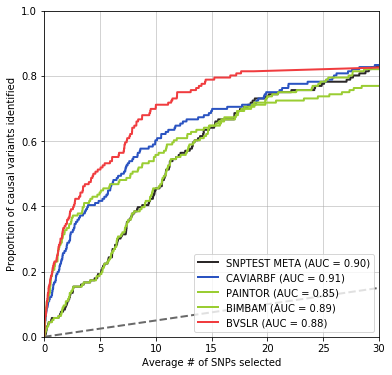

In [32]:
import matplotlib.pyplot as plt
from sklearn import metrics
import receiving_operating_characteristic as roc

colors = ['#2A53C1', '#F03C3F', 'yellowgreen', '#2B2828']
figsize = (6,6)
marker_list = ['8', '>', 'd', '<', '*', 'p', '^', 's', 'h', 'v', 'D', r'$\clubsuit$']
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 1, 1)
xx = [0, 200]
yy = [0,1]
ax1.plot(xx, yy, '--', color='dimgrey', lw=2)

#P-VALUES
fpr_py, tpr_py, thresholds = metrics.roc_curve(actual_logpval, estimated_logpval)
fpr, tpr, precision, recall, nselected, auc = roc.roc_values(actual_logpval, estimated_logpval, 0)
nselected = np.array(nselected).astype(float) / nloci
auc_py = metrics.auc(fpr_py, tpr_py)
color = colors[3]
linestyle = 'solid'
mlabel_roc_py = 'SNPTEST META (AUC = ' + "%3.2f" % auc_py + ')'
#ax1.plot(fpr_py, tpr_py, color=color, linestyle=linestyle, lw=2, label=mlabel_roc_py)
ax1.plot(nselected, recall, color=color, linestyle=linestyle, lw=2, label=mlabel_roc_py)

# CAVIARBF
fpr_py, tpr_py, thresholds = metrics.roc_curve(actual_caviarbf, estimated_caviarbf)
fpr, tpr, precision, recall, nselected, auc = roc.roc_values(actual_caviarbf, estimated_caviarbf, 0)
nselected = np.array(nselected).astype(float) / nloci
auc_py = metrics.auc(fpr_py, tpr_py)
color = colors[0]
linestyle = 'solid'
mlabel_roc_py = 'CAVIARBF (AUC = ' + "%3.2f" % auc_py + ')'
#ax1.plot(fpr_py, tpr_py, color=color, linestyle=linestyle, lw=2, label=mlabel_roc_py)
ax1.plot(nselected, recall, color=color, linestyle=linestyle, lw=2, label=mlabel_roc_py)

#PAINTOR
fpr_py, tpr_py, thresholds = metrics.roc_curve(actual_paintor, estimated_paintor)
fpr, tpr, precision, recall, nselected, auc = roc.roc_values(actual_paintor, estimated_paintor, 0)
nselected = np.array(nselected).astype(float) / nloci
auc_py = metrics.auc(fpr_py, tpr_py)
color = colors[2]
linestyle = 'solid'
mlabel_roc_py = 'PAINTOR (AUC = ' + "%3.2f" % auc_py + ')'
#ax1.plot(fpr_py, tpr_py, color=color, linestyle=linestyle, lw=2, label=mlabel_roc_py)
ax1.plot(nselected, recall, color=color, linestyle=linestyle, lw=2, label=mlabel_roc_py)


# BIMBAM
fpr_py, tpr_py, thresholds = metrics.roc_curve(actual_bimbam, estimated_bimbam)
fpr, tpr, precision, recall, nselected, auc = roc.roc_values(actual_bimbam, estimated_bimbam, 0)
nselected = np.array(nselected).astype(float) / nloci
auc_py = metrics.auc(fpr_py, tpr_py)
color = colors[2]
linestyle = 'solid'
mlabel_roc_py = 'BIMBAM (AUC = ' + "%3.2f" % auc_py + ')'
#ax1.plot(fpr_py, tpr_py, color=color, linestyle=linestyle, lw=2, label=mlabel_roc_py)
ax1.plot(nselected, recall, color=color, linestyle=linestyle, lw=2, label=mlabel_roc_py)

#BVSLR
fpr_py, tpr_py, thresholds = metrics.roc_curve(actual_bvslr, estimated_bvslr)
fpr, tpr, precision, recall, nselected, auc = roc.roc_values(actual_bvslr, estimated_bvslr, 0)
nselected = np.array(nselected).astype(float) / nloci
auc_py = metrics.auc(fpr_py, tpr_py)
color = colors[1]
linestyle = 'solid'
mlabel_roc_py = 'BVSLR (AUC = ' + "%3.2f" % auc_py + ')'
#ax1.plot(fpr_py, tpr_py, color=color, linestyle=linestyle, lw=2, label=mlabel_roc_py)
ax1.plot(nselected, recall, color=color, linestyle=linestyle, lw=2, label=mlabel_roc_py)



ax1.set_xlim([0,200])
ax1.set_ylim([0,1])
ax1.set_xlabel('Average # of SNPs selected')
ax1.set_ylabel('Proportion of causal variants identified')
ax1.legend(loc='lower right')
ax1.grid(color='darkgrey', lw=0.5)

ax1.set_xlim(0, 30)

plt.show()

In [8]:
bsort = np.argsort(estimated_bvslr)
estimated_bvslr[bsort]

array([ 0.      ,  0.      ,  0.      , ...,  0.532642,  0.708151,
        0.768583])

In [20]:
np.array(nselected).astype(float) / nloci

array([  0.00000000e+00,   2.50000000e-05,   5.00000000e-05, ...,
         9.38750000e-02,   9.39000000e-02,   1.00077500e+00])

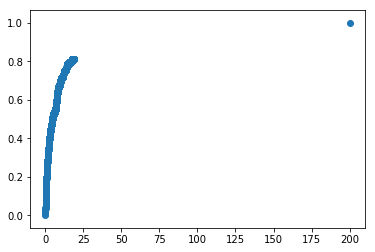

In [28]:
fig = plt.figure()
plt.scatter(nselected, recall)
plt.show()